In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from collections import defaultdict
from scipy.stats import pearsonr, spearmanr, kendalltau
from glob import glob

In [39]:
def _get_instance_level_correlation(data: pd.DataFrame, metrics: list, target_col: str, corr_method: callable) -> dict:
    name = corr_method.__name__
    print("Computing", name, "with", target_col, "col")
    
    # Pseudo algorithm
    # 1. Iterate over each doc_id
    # 2. Compute the correlation between different metric values for each doc_id and the human values
    # 3. Avg correlation coefficients in the end
    instance_level_corrs = defaultdict(list)

    for iid in data["bartscore_doc_id"].unique():
        for m in metrics:
            instance = data[data["bartscore_doc_id"] == iid]
            corr, p_val = corr_method(instance[m], instance[target_col])
            instance_level_corrs[m].append(corr)
           
    # Compute the avg (#TODO - handle p_val)
    instance_level_corrs_avg = {metric: np.mean(corr_data) for metric, corr_data in instance_level_corrs.items()}
    return instance_level_corrs_avg


def compute_instance_level_correlations(data, metrics, target_col, dataset_name, output_dir, to_persist=True, **_):
    correlations = {}
    for corr_method in (pearsonr, spearmanr, kendalltau):
        result = _get_instance_level_correlation(data, metrics, target_col, corr_method)

        correlations[corr_method.__name__] = result

    correlations = pd.DataFrame(correlations)
    if to_persist:
        os.makedirs(output_dir, exist_ok=True)
        correlations.reset_index().to_csv(f"{output_dir}/{dataset_name}_instance_corrs.csv", index=0)
    
    return correlations


def _get_system_level_correlation(data, metrics, target_col, systems, corr_method: callable) -> dict:
    # pseudo code
    # for each system
    # compute the mean score attributed by a metric m to the outputs of each system.
    # compute the mean score attributed by a target_col to the outputs of each system.
    # compute correlation
    system_level_correlation = defaultdict(list)
    for sys in systems:
        data_sys = data[data["sys_name"] == sys]
        # ^Note: since we're computing the mean, we dont need to ensure the ordering

        for m in metrics + [target_col]:
            mean_sys = data_sys[m].mean()
            system_level_correlation[m].append(mean_sys)

    # Compute the correlation now
    correlations = {}
    for m in metrics:
        corr, p_val = corr_method(system_level_correlation[m], system_level_correlation[target_col])

        correlations[m] = round(corr, 4)

    return correlations


def compute_system_level_correlations(data, metrics, target_col, dataset_name, systems, output_dir, to_persist=True, **_):

    correlations = {}
    for corr_method in (pearsonr, spearmanr, kendalltau):
        result = _get_system_level_correlation(data, metrics, target_col, systems, corr_method)
        correlations[corr_method.__name__] = result

    correlations = pd.DataFrame(correlations)
    if to_persist:
        os.makedirs(output_dir, exist_ok=True)
        correlations.reset_index().to_csv(f"{output_dir}/{dataset_name}_system_corrs.csv", index=0)
    
    return correlations

In [40]:
TARGET_COL = "litepyramid_recall"
DATASET_NAME = "realsumm"
DATASET_DIR = "../datasets/summ_data/REALSumm/quantile"

dfs = []
for split in ("all", "train", "dev", "test"):
    df = pd.read_csv(f"{DATASET_DIR}/2class_{split}.csv")
    for col in ("bert_score_p", "bert_score_r", "bert_score_f"):
        if col in df.columns:
            df[col] = df[col].apply(lambda s: s.replace("tensor", "")[1:-1]).apply(float)

    dfs.append(df)
    
all_df, train_df, dev_df, test_df = dfs

In [65]:
METRICS = [
    # BERTScore
    'bert_score_p','bert_score_r','bert_score_f',
    'mover_score',
    # PRISM
    'prism_ref_hypo','prism_hypo_ref','prism_avg','prism_src_hypo',
    # ROUGE
    'rouge1_r','rouge1_p','rouge1_f',
    'rouge2_r','rouge2_p','rouge2_f',
    'rougel_r','rougel_p','rougel_f',
    # BARTScore
    'bart_score_cnn_ref_hypo_en', 'bart_score_cnn_ref_hypo_de',
    'bart_score_cnn_hypo_ref_en','bart_score_cnn_hypo_ref_de',
    'bart_score_cnn_avg_f_en','bart_score_cnn_avg_f_de',
    'bart_score_cnn_harm_f_en','bart_score_cnn_harm_f_de',
    'bart_score_src_hypo','bart_score_hypo_ref','bart_score_ref_hypo','bart_score_avg_f','bart_score_harm_f',
    'bart_score_cnn_src_hypo','bart_score_cnn_hypo_ref','bart_score_cnn_ref_hypo','bart_score_cnn_avg_f','bart_score_cnn_harm_f',
    'bart_score_para_src_hypo','bart_score_para_hypo_ref','bart_score_para_ref_hypo','bart_score_para_avg_f','bart_score_para_harm_f',
]
systems = sorted(all_df["sys_name"].unique())

instance_baseline_corrs = []
system_baseline_corrs = []
        
print("-" * 80)
print("Computing correlations for AUTOMATED METRICS")
print("-" * 80)

instance_corr_metrics = compute_instance_level_correlations(
    dev_df,
    metrics=METRICS,
    target_col=TARGET_COL,
    dataset_name=f"{DATASET_NAME.lower()}",
    output_dir="",
    to_persist=False,
)

system_corr_metrics = compute_system_level_correlations(
    dev_df, 
    metrics=METRICS,
    target_col=TARGET_COL,
    dataset_name=f"{DATASET_NAME.lower()}",
    output_dir="",
    systems=systems,
    to_persist=False
)

--------------------------------------------------------------------------------
Computing correlations for AUTOMATED METRICS
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col


In [66]:
instance_corr_metrics.sort_values("kendalltau", ascending=False).head()

,pearsonr,spearmanr,kendalltau
rouge1_r,0.504086,0.495660,0.408431
rougel_r,0.490841,0.483612,0.399427
bart_score_para_hypo_ref,0.476355,0.460115,0.361451
bart_score_cnn_hypo_ref_de,0.441228,0.450739,0.355831
bert_score_r,0.468425,0.442485,0.350874


<AxesSubplot:>

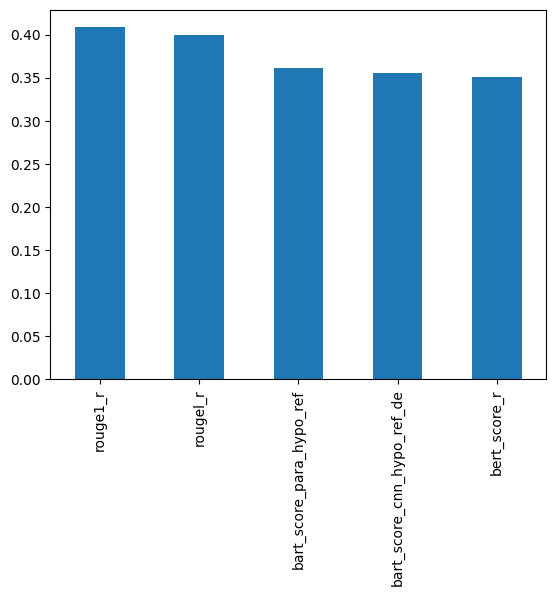

In [67]:
instance_corr_metrics.sort_values("kendalltau", ascending=False).head()["kendalltau"].plot(kind="bar")

<AxesSubplot:>

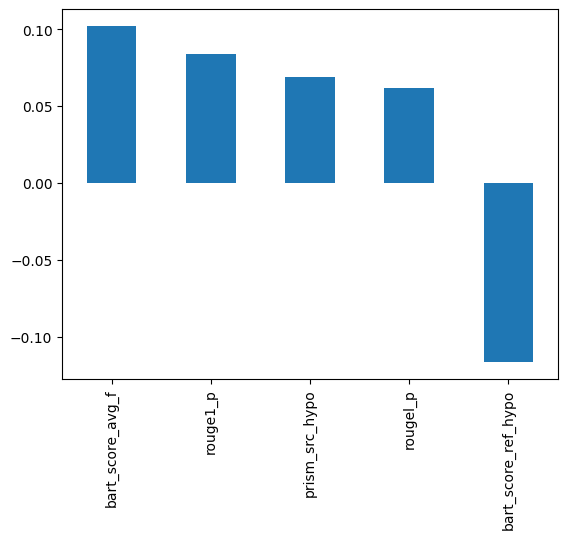

In [68]:
instance_corr_metrics.sort_values("kendalltau", ascending=False).tail()["kendalltau"].plot(kind="bar")

In [69]:
system_corr_metrics.sort_values("kendalltau", ascending=False).head()

,pearsonr,spearmanr,kendalltau
rouge2_r,0.8273,0.8696,0.7029
rougel_r,0.7709,0.7974,0.6232
rouge1_r,0.7916,0.8183,0.6232
bart_score_cnn_hypo_ref_de,0.6617,0.7652,0.5942
bart_score_cnn_hypo_ref,0.6698,0.7783,0.5942


<AxesSubplot:>

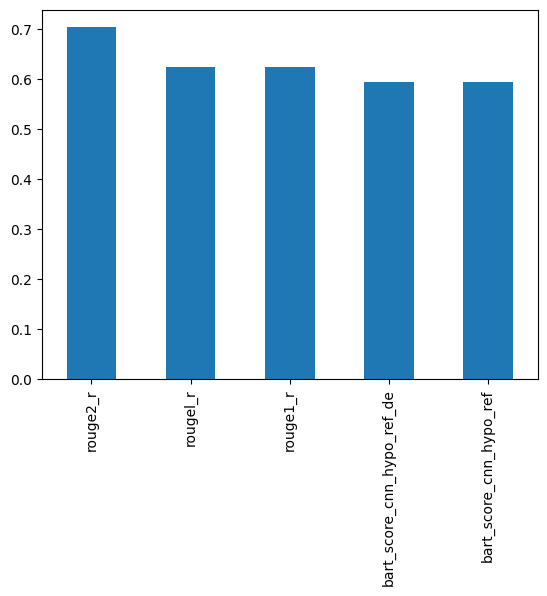

In [70]:
system_corr_metrics.sort_values("kendalltau", ascending=False).head()["kendalltau"].plot(kind="bar")

<AxesSubplot:>

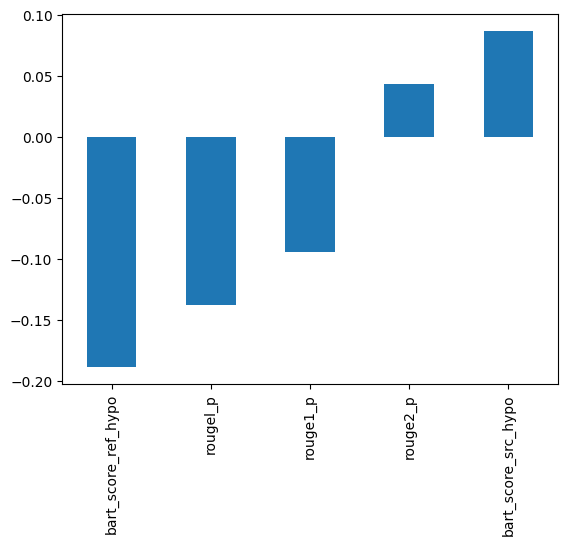

In [71]:
system_corr_metrics.sort_values("kendalltau").head()["kendalltau"].plot(kind="bar")

In [49]:
output_dir = f"../t-few-master/experiments_balanced/realsumm_2class/evals"
dev_files = sorted(glob(os.path.join(output_dir, "*", "dev_pred.txt")))
print(f"Find {len(dev_files)} experiments")
print()

def extract_name(path):
    # Given a path in the format
    # './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train/<something>
    # 1. Extract the parent dir `t03b_realsumm_baseline_ft_train`
    exp_name = path.split("/")[-2]

    # 2. Keep all parts including baseline and afterwards
    index_baseline = exp_name.index("baseline")
    return exp_name[index_baseline:]


dev_data = {extract_name(path): pd.read_csv(path) for path in dev_files}

# Before returning the dataframe, we will recover the bartscore_doc_id
# to facilitate re-use of previous correlation methods.
dev_baselines = {}
for baseline, data in dev_data.items():
    data = data.merge(dev_df, left_on="idx", right_on="index", suffixes=(None, "_orig"))

    dev_baselines[baseline] = data
    assert (data["label"] == data["label_orig"]).all()

Find 40 experiments



In [73]:
dataset_name = "realsumm"
target_col = "litepyramid_recall"
split_baselines = dev_baselines
systems = sorted(data["sys_name"].unique())

instance_baseline_corrs = []
system_baseline_corrs = []
        
for baseline, data in split_baselines.items():
    print("\n" * 4)
    print("-" * 80)
    print("Computing correlations for", baseline)
    print("-" * 80)

    instance_corr = compute_instance_level_correlations(
        data,
        metrics=["log.scores_class_1"],
        target_col=target_col,
        dataset_name=f"{dataset_name.lower()}_{baseline}",
        output_dir="",
        to_persist=False,
    )

    system_corr = compute_system_level_correlations(
        data, 
        metrics=["log.scores_class_1"],
        target_col=target_col,
        dataset_name=f"{dataset_name.lower()}_{baseline}",
        output_dir="",
        systems=systems,
        to_persist=False
    )

    instance_corr["index"] = baseline
    system_corr["index"] = baseline

    instance_baseline_corrs.append(instance_corr)
    system_baseline_corrs.append(system_corr)

instance_baseline_corrs = pd.concat(instance_baseline_corrs)
system_baseline_corrs = pd.concat(system_baseline_corrs)






--------------------------------------------------------------------------------
Computing correlations for baseline_ia3_pretrained100k_ft_train_ia3_template_0
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col





--------------------------------------------------------------------------------
Computing correlations for baseline_ia3_pretrained100k_ft_train_ia3_template_1
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col





--------------------------------------------------------------------------------
Computing correlations for baseline_ia3_pretrained100k_ft_train_ia3_template_2
-------------------------------------------------------

Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col





--------------------------------------------------------------------------------
Computing correlations for baseline_no_ckpt_ft_train_ia3_template_7
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col





--------------------------------------------------------------------------------
Computing correlations for baseline_no_ckpt_ft_train_no_ia3_template_0
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col





--------------------------------------------------------------------------------
Computing correlations for baseline_no_ckpt_ft_train_no_

In [74]:
def extract_template(name):
    template_no = name.rpartition("_")[-1]
    return template_no
    

def extract_basename(name):
    index = name.index("_template")
    return name[:index]


instance_baseline_corrs["eval_template"] = instance_baseline_corrs["index"].apply(extract_template)
instance_baseline_corrs["basename"] = instance_baseline_corrs["index"].apply(extract_basename)

system_baseline_corrs["eval_template"] = system_baseline_corrs["index"].apply(extract_template)
system_baseline_corrs["basename"] = system_baseline_corrs["index"].apply(extract_basename)

In [79]:
instance_baseline_corrs.sort_values("kendalltau", ascending=False).head()

,pearsonr,spearmanr,kendalltau,index,eval_template,basename
log.scores_class_1,0.413516,0.409236,0.315039,baseline_no_ckpt_ft_train_no_ia3_template_4,4,baseline_no_ckpt_ft_train_no_ia3
log.scores_class_1,0.409609,0.401659,0.307365,baseline_no_ckpt_ft_train_no_ia3_template_2,2,baseline_no_ckpt_ft_train_no_ia3
log.scores_class_1,0.397936,0.396799,0.306891,baseline_no_ckpt_ft_train_no_ia3_template_7,7,baseline_no_ckpt_ft_train_no_ia3
log.scores_class_1,0.407135,0.392010,0.302198,baseline_no_ckpt_ft_train_no_ia3_template_3,3,baseline_no_ckpt_ft_train_no_ia3
log.scores_class_1,0.402520,0.391395,0.298937,baseline_no_ckpt_ft_train_no_ia3_template_5,5,baseline_no_ckpt_ft_train_no_ia3


0    361
1    359
Name: prediction, dtype: int64
0    420
1    300
Name: label, dtype: int64


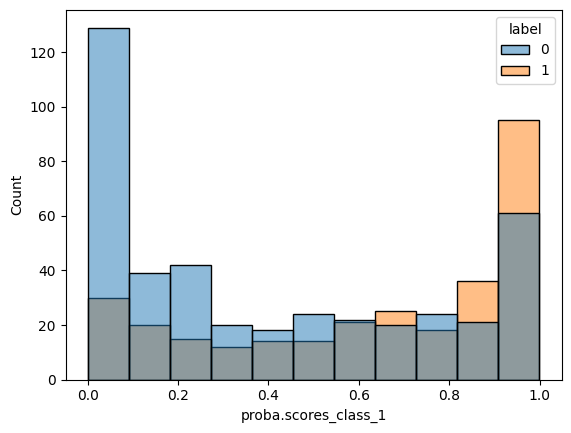

In [101]:
d = dev_baselines["baseline_no_ckpt_ft_train_no_ia3_template_4"].copy()
d["proba.scores_class_1"] = d["log.scores_class_1"].apply(np.exp)
sns.histplot(data=d, x="proba.scores_class_1", hue="label")

print(d.prediction.value_counts())
print(d.label.value_counts())

0    384
1    336
Name: prediction, dtype: int64
0    420
1    300
Name: label, dtype: int64


0    420
1    300
Name: label, dtype: int64

<AxesSubplot:xlabel='kendalltau', ylabel='basename'>

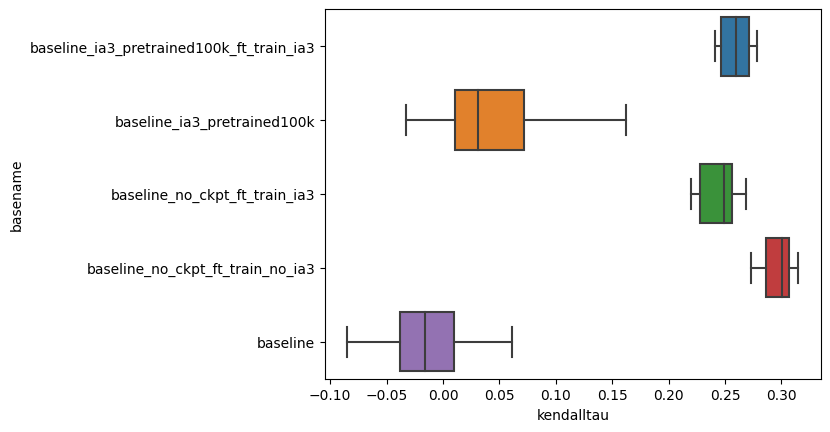

In [86]:
sns.boxplot(data=instance_baseline_corrs, y="basename", x="kendalltau")

In [93]:
system_baseline_corrs.sort_values("kendalltau", ascending=False).head()

,pearsonr,spearmanr,kendalltau,index,eval_template,basename
log.scores_class_1,0.7756,0.7617,0.5725,baseline_no_ckpt_ft_train_no_ia3_template_7,7,baseline_no_ckpt_ft_train_no_ia3
log.scores_class_1,0.7815,0.7539,0.5652,baseline_no_ckpt_ft_train_no_ia3_template_3,3,baseline_no_ckpt_ft_train_no_ia3
log.scores_class_1,0.7816,0.7435,0.5580,baseline_no_ckpt_ft_train_no_ia3_template_4,4,baseline_no_ckpt_ft_train_no_ia3
log.scores_class_1,0.7817,0.7400,0.5507,baseline_no_ckpt_ft_train_no_ia3_template_1,1,baseline_no_ckpt_ft_train_no_ia3
log.scores_class_1,0.7799,0.7252,0.5435,baseline_no_ckpt_ft_train_no_ia3_template_2,2,baseline_no_ckpt_ft_train_no_ia3


0    384
1    336
Name: prediction, dtype: int64
0    420
1    300
Name: label, dtype: int64


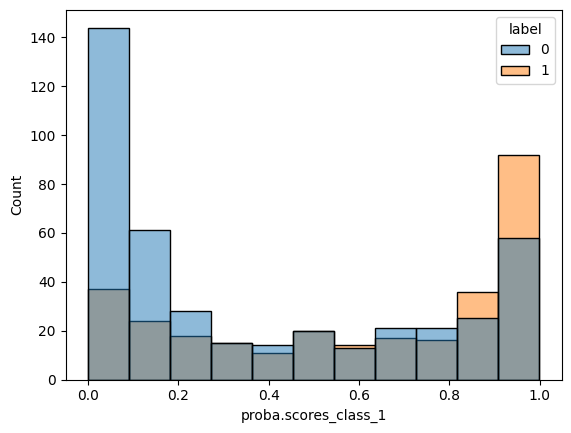

In [100]:
d = dev_baselines["baseline_no_ckpt_ft_train_no_ia3_template_7"].copy()
d["proba.scores_class_1"] = d["log.scores_class_1"].apply(np.exp)
sns.histplot(data=d, x="proba.scores_class_1", hue="label")

print(d.prediction.value_counts())
print(d.label.value_counts())

<AxesSubplot:xlabel='kendalltau', ylabel='basename'>

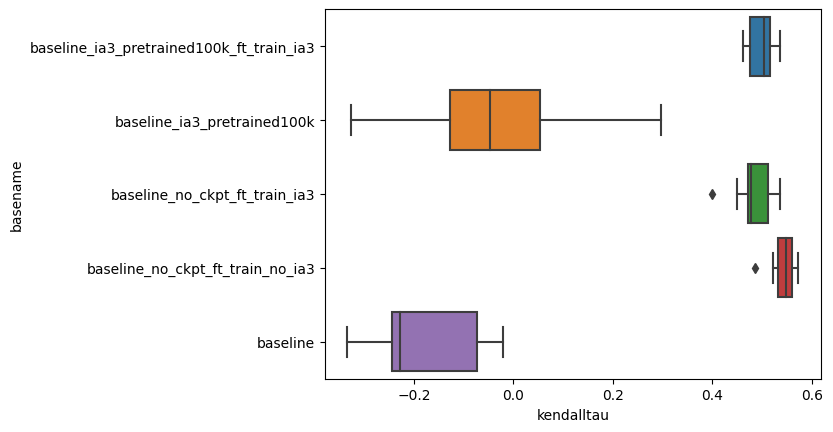

In [62]:
sns.boxplot(data=system_baseline_corrs, y="basename", x="kendalltau")

<AxesSubplot:xlabel='kendalltau', ylabel='eval_template'>

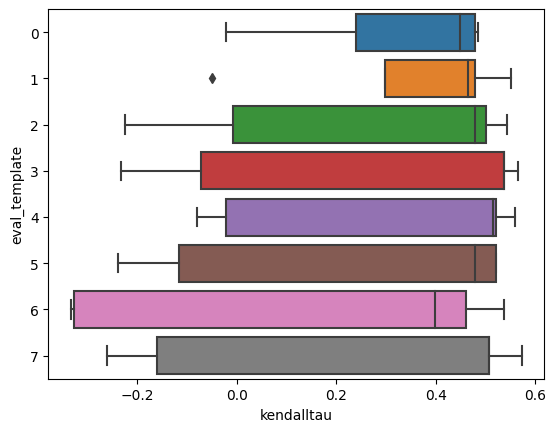

In [106]:
sns.boxplot(data=system_baseline_corrs, y="eval_template", x="kendalltau")